In [1]:
import io
import pytesseract
from pdf2image import convert_from_path
from PIL import Image, ImageEnhance, ImageDraw, ImageFont
from pytesseract import Output
import cv2
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from difflib import SequenceMatcher
import json


In [2]:
def word2Line(OCRResult):
    data = {}
    for i in range(len(OCRResult['line_num'])):
        txt = OCRResult['text'][i]
        block_num = OCRResult['block_num'][i]
        line_num = OCRResult['line_num'][i]
        top, left = OCRResult['top'][i], OCRResult['left'][i]
        width, height = OCRResult['width'][i], OCRResult['height'][i]
        if not (txt == '' or txt.isspace()):
            tup = (txt, left, top, width, height)
            if block_num in data:
                if line_num in data[block_num]:
                    data[block_num][line_num].append(tup)
                else:
                    data[block_num][line_num] = [tup]
            else:
                data[block_num] = {}
                data[block_num][line_num] = [tup]

    linedata = {}
    idx = 0
    for _, b  in data.items():
        for _, l in b.items():
            linedata[idx] = l
            idx += 1
    
    return linedata

def isPointInsideBbox(point, bbox):
    return bbox[0] <= point[0] <= bbox[2] and bbox[1] <= point[1] <= bbox[3]


# Try to use clustering to group address bboxes

{
    "Shipper": "Shipper ( \u53d1 \u8d27 \u4eba )\nZHEJIANG QIAOYUAN INDUSTRY & TRADE\nC0. , LIMITED\nROO0M 501,FUTIAN BUILDING SITEB ANO. 1121\nCHOUZHOU NORTIH ROAD, YIWU, ZHEJIANG CHINA\nTEL:0579-85420006FAX:057985256158\n",
    "Consignee": "Consignee ( \u6536 \u8d27 \u4eba )\nK002-901638004#YUN SHUN (CAMBODIA)\nIMPORT EXPORT TRADE C0. ,LTD\n#NO, 48 ST:374 SO0NG KAT TOUL SVAI PREY KHAN\nCHAMKAMORN PHNOM PENH CAMBODIA\n#TELL:023216095#FAX:023216095\n",
    "Notify": "Notity Party ( \u901a \u544a \u4eba )\n0309345377#TIAD L0GISTICS C0. , LTID\n#47 TRAN TAN,TAN SON NHL WRD TAN PHU\nDISTRICT ,HOCHIMINH CITY,VIETNAM.\n#TEL:84~8-38124098#FAX: 84-8-38108980\n#PTC:HUY NH DUC\n"
}


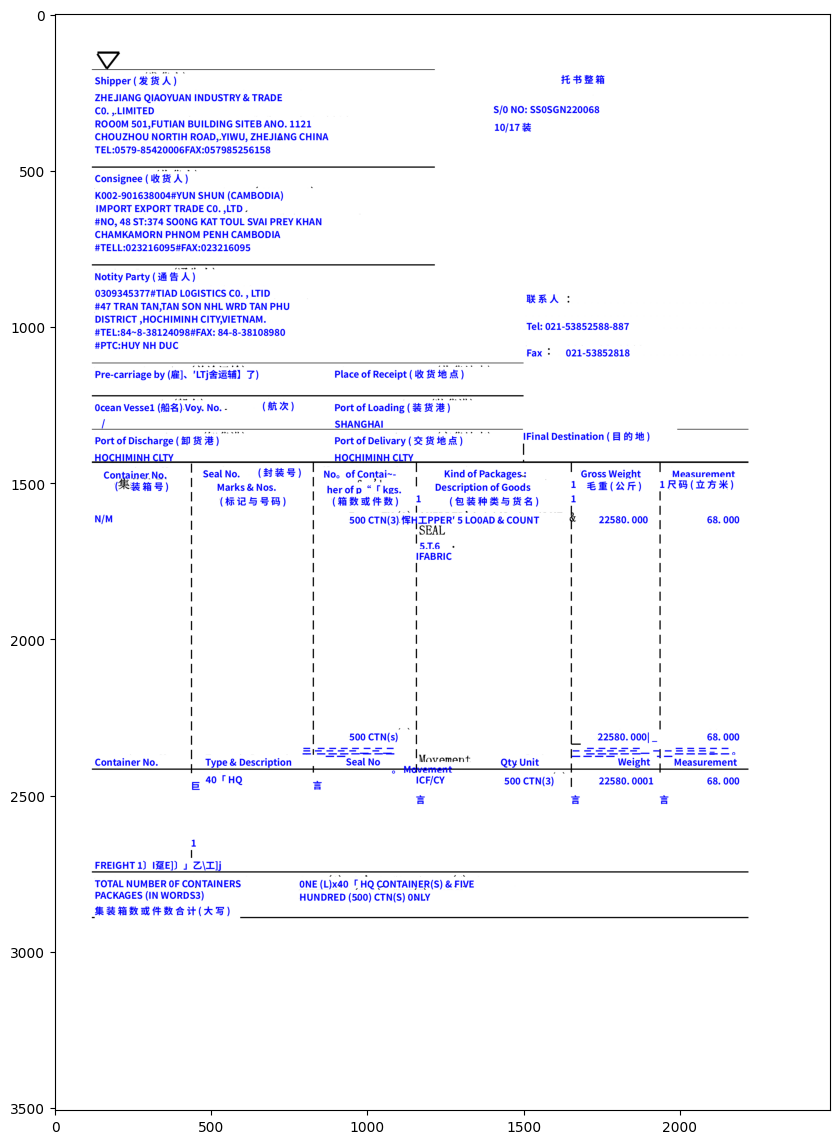

In [5]:
fileName = Path('example2.pdf')
dpi = 300
image = convert_from_path(fileName,dpi)[0]
text = pytesseract.image_to_data(image, output_type=Output.DICT,config= f'-l chi_sim --psm 12')
linedata = word2Line(text)
markArray = np.zeros((image.size[1], image.size[0]), dtype=np.uint8)
line_idx = 1
font = ImageFont.truetype('NotoSansSC-Bold.ttf', dpi//10)
draw = ImageDraw.Draw(image)
for _, line in linedata.items():
    text = " ".join([i[0] for i in line])
    xmin, ymin = line[0][1], line[0][2]
    xmax, ymax = (line[-1][1] + line[-1][3]), (line[-1][2] + line[-1][4])
    # print("Line {} : {}, {}, {}, {}, {}".format(line_idx, xmin, ymin, xmax, ymax, text))
    cv2.circle(markArray, (xmin, ymin), 10, (255), -1)
    #draw text and bbox
    # draw.rectangle([(xmin, ymin), (xmax, ymax)], outline ="red",width=dpi//150)
    draw.rectangle([(xmin, ymin), (xmax, ymax)], (255,255,255))
    draw.text((xmin, ymin),  text, font = font, fill = (0, 0, 255, 255))
    
    
    line_idx += 1


dist = cv2.distanceTransform(~markArray, cv2.DIST_L1, 3)
# max distance
'''
-l chi_sim, dpi=300, k=30
example.pdf
example2.pdf

-l eng, dpi=300, k=30
../Sample_files/awards/1407_001.pdf
../Sample_files/awards/1527_001.pdf   文字唔同行 if lineDiff = 1 then y1 - y2
../Sample_files/awards/1977_001.pdf
../Sample_files/awards/ASLHCM100395- HCM.pdf xxx
../Sample_files/awards/ASLSIN1901168.pdf

exampl-e.pdf 發貨人同地址太近，OCR錯誤

'''
k = 20
bw = np.uint8(dist < k)
# clusters
contours, _ = cv2.findContours(bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# draw clusters and bounding-boxes

drawImage = np.array(image.copy())

textList = []
addressNum = 3

for cnt in contours:
    text = ""
    maxLength = 0
    x, y, w, h = cv2.boundingRect(cnt)
    cv2.rectangle(markArray, (x, y), (x+w, y+h), (255), 2)
    # cv2.rectangle(drawImage, (x, y), (x+w, y+h), (0,0,0), 2)
    for _, line in linedata.items():
        xmin, ymin = line[0][1], line[0][2]
        if isPointInsideBbox((xmin, ymin), (x, y, x+w, y+h)):
            lineText = " ".join([i[0] for i in line])
            text += lineText + '\n'
            maxLength = max(maxLength, len(lineText))
            
    if maxLength > 25:
        textList.append({'text':text, 'bbox':[x, y, w, h], "maxLength":maxLength})
        
    similarity = SequenceMatcher(None, lineText.upper(), "SAME AS CONSIGNEE").ratio()
    if similarity >= 0.9:
        addressNum = 2
    
textList = sorted(textList, key=lambda x: len(x['text']), reverse=True)
address = textList[:addressNum]
address = sorted(address, key=lambda x: x['bbox'][1])#sort by bbox y
# print(address)
if addressNum == 3:
    address = {"Shipper":address[0]['text'], 'Consignee':address[1]['text'], "Notify":address[2]['text']}
else:#Notify address ams as Consignee
    address = {"Shipper":address[0]['text'], 'Consignee':address[1]['text'], "Notify":address[1]['text']}
    

json_like_string = json.dumps(address, indent=4)
# Print the JSON-like string
print(json_like_string)

# plt.figure(figsize=(10,15))
# plt.imshow(markArray, cmap='gray')
# plt.show()

plt.figure(figsize=(10,15))
plt.imshow(drawImage)
plt.show()




# Draw Bbox on pdf to see the OCR result

In [42]:


image = convert_from_path(fileName,dpi)[0]

# image = np.asarray(image)
#swap color channel ordering from BGR (OpenCV’s default) to RGB (compatible with Tesseract and pytesseract).
# By default OpenCV stores images in BGR format and since pytesseract assumes RGB format,
# we need to convert from BGR to RGB format/mode:

# rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
whitelist = '0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ(\u53D1\u8D27\u4EBA)\u6536\u8D27\u4EBA\u901A\u543F\u4EBA\u901A\u77E5\u4EBA :-#,.&/'
results = pytesseract.image_to_data(image, output_type=Output.DICT,config= f'-l chi_sim --psm 12')
# results = pytesseract.image_to_data(image, output_type=Output.DICT,config= f'-l eng+chi_sim --psm 12')

font = ImageFont.truetype('NotoSansSC-Bold.ttf', dpi//10)
draw = ImageDraw.Draw(image)
print(results.keys())

for i in range(len(results["text"])):
    # extract the bounding box coordinates of the text region from the current result
    tmp_tl_x = results["left"][i]
    tmp_tl_y = results["top"][i]
    tmp_br_x = tmp_tl_x + results["width"][i]
    tmp_br_y = tmp_tl_y + results["height"][i] 
    tmp_level = results["level"][i]
    conf = results["conf"][i]
    text = results["text"][i]
    print(text, tmp_level)
    if(tmp_level == 5):
        
        draw.text((tmp_tl_x, tmp_tl_y - dpi//10),  text, font = font, fill = (0, 0, 255, 255))
        draw.rectangle([(tmp_tl_x, tmp_tl_y), (tmp_br_x, tmp_br_y)], outline ="red",width=dpi//150)

image.show()


dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])
 1
 2
 3
 4
宁 5
波 5
中 5
工 5
美 5
进 5
出 5
口 5
有 5
限 5
责 5
任 5
公 5
司 5
 2
 3
 4
NINGBO 5
CNACC 5
IMPORT 5
& 5
EXPORT 5
CO., 5
LTD 5
 2
 3
 4
口 5
货 5
物 5
明 5
 2
 3
 4
绑 5
 2
 3
 4
E 5
 2
 3
 4
NINGBO 5
CNACC 5
IMPORT 5
AND 5
EXPORT 5
CO. 5
, 5
 2
 3
 4
LTD 5
 2
 3
 4
NO. 5
598,SOUTH 5
KANGZHUANG 5
ROAD 5
 2
 3
 4
NINGBO, 5
CHINA 5
 2
 3
 4
…`且…^ 5
 2
 3
 4
L 5
与 5
- 5
 2
 3
 4
MAISONS 5
DU 5
MONDE 5
3AS 5
 2
 3
 4
LBE 5
PORTEREAU 5
BP 5
52402-44124 5
 2
 3
 4
唐 5
国 5
一 5
二 5
一 5
 2
 3
 4
VERTOU 5
CEDEX 5
 2
 3
 4
贝′寥'〕 5
 2
 3
 4
国 5
别 5
( 5
 2
 3
 4
价 5
格 5
 2
 3
 4
又 5
士′「 5
 2
 3
 4
乙 5
区 5
) 5
 2
 3
 4
| 5
 2
 3
 4
文看车百首 5
 2
 3
 4
SAMBE 5
AS 5
CONSIGNEE 5
 2
 3
 4
钥 5
限 5
 2
 3
 4
咫99 5
12-30 5
 2
 3
 4
团 5
E 5
 2
 3
 4
胍一 5
 2
 3
 4
昌 5
 2
 3
 4
5 5
吴 5
吊 5
5 5
国 5
国 5
国 5
春 5
命 5
 2
 3
 4
FORMA 5
“ 5
收 5
货 5
 2
 3
 4
人 5
名 5
称 5
及 5
地 5
址 5
 2
 3
 4
H 5


In [ ]:
{
    "Shipper": """ZHEJIANG QIAOYUAN INDUSTRY & TRADE
    C0. , LIMITED
    ROO0M 501,FUTIAN BUILDING SITEB ANO. 1121
    CHOUZHOU NORTIH ROAD, YIWU, ZHEJIANG CHINA
    TEL:0579-85420006FAX:057985256158
    """,
    "Consignee": """K002-901638004#YUN SHUN (CAMBODIA)
    IMPORT EXPORT TRADE C0. ,LTD
    #NO, 48 ST:374 SO0NG KAT TOUL SVAI PREY KHAN
    CHAMKAMORN PHNOM PENH CAMBODIA
    #TELL:023216095#FAX:023216095
    """,
    "Notify": """0309345377#TIAD L0GISTICS C0. , LTID
    #47 TRAN TAN,TAN SON NHL WRD TAN PHU
    DISTRICT ,HOCHIMINH CITY,VIETNAM.
    #TEL:84~8-38124098#FAX: 84-8-38108980
    #PTC:HUY NH DUC
    """
}

